In [6]:
#| default_exp regress_ml

# Train ML model

In [7]:
#|hide
from nbdev.showdoc import *

In [8]:
#|hide
#|export
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from ML_projects import const_vals as CONST
from ML_projects import rf_reg as rf_reg


import warnings
warnings.filterwarnings('ignore')

In [4]:
#|export 
class TrainRegression():
       
       def __init__(self,
               df_path : str , # path to dataframe to be used to train. File should be CSV file
               requested_model : str , # model to train. Options : 'RFR' 'XGB' 'SVR' 'RIDGE' 'KNEIGHBORS' 'GRADIENT_BOOST' 'ADA'
               ground_truth_col: str, # name of the column with true data to train
               test_size : float , #size of data to be used for test 
               hyper_method : str , #hyperparameter tunning method. accepts : 'randomized' 'bayesian' , 'bayesian continous'
               columns_to_remove : list[str]=None , #columns not to use for trainning the model. These columns will be removed.
              #  hyper_params : dict = CONST.RANDOM_GRID_RFR, #parameters for hyperparameter tunning
              #  space : list = CONST.SPACE_RFR  , #
               ):
             self.df_path = df_path
             self.columns_to_remove = columns_to_remove
             self.ground_truth_col = ground_truth_col
             self.test_size = test_size
             self.hyper_method = hyper_method

             #load data and get train test data
             self.x_train, self.x_test, self.y_train, self.y_test = self._load_df_split_data()
             
             # create initial model and match the params 

             self.model_str = requested_model
       

       def _match_model_(self):

              if self.model_str == 'RFR':
                     



             

       #       self.hyper_params = hyper_params
       #       self.space = space

       #       self.the_best_model = rf_reg.TrainRFReg(train_test_data = [self.x_train, self.x_test, self.y_train, self.y_test],
       #                         hyper_method = self.hyper_method,
       #                         hyper_params = self.hyper_params,
       #                         space = self.space
       #                         )
             
       def _load_df_split_data(self):
               
               self.df = pd.read_csv(self.df_path)
               #load dataframe
               if self.columns_to_remove!= None:
                     self.df = self.df.drop(self.columns_to_remove,axis=1)
          
               # split to x,y and train test data
               self.x = self.df.drop(self.ground_truth_col,axis=1)
               self.y = self.df[self.ground_truth_col].values

               #split data to train and test
               self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(
                      self.x, self.y, test_size=self.test_size, random_state=42)

               return self.x_train, self.x_test, self.y_train, self.y_test
       



 




best params : OrderedDict({'bootstrap': True, 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200})
MAE : 0.33337426607209175 , MSE: 0.3828594100231825 , RMSE : 0.6187563414003792 MAPE : 79.81536122071904 


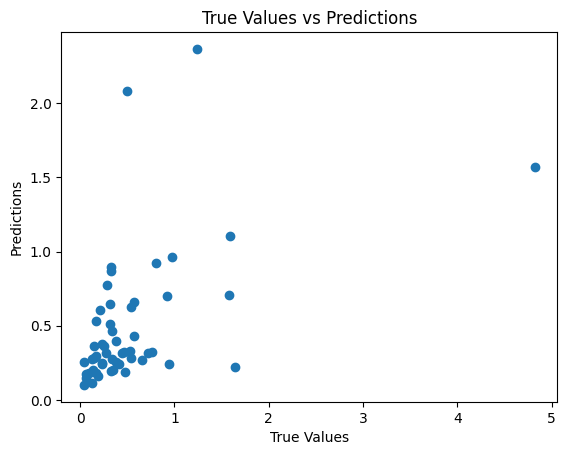

In [5]:
instance = TrainRegression(
  df_path=r"D:\git\ML_projects\nbs\data\resampled_sen2.csv",
  ground_truth_col = "TOC",
  test_size = 0.25,
  columns_to_remove = ['Unnamed: 0.1', 'Unnamed: 0', 'Lon', 'Lat', 'clay', 'silt','sand', 'NI'],
  hyper_method = 'bayesian'    
  
                    )
# test = instance.the_best_model
# print(instance.the_best_params)


In [ ]:
print(test)